# **1. Importing Libraries**

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import math

# **2. Loading and Preprocessing the Data**

In [74]:
df = pd.read_csv('AirPassengers.csv')
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Log-transform passenger counts to stabilize variance
log_passengers = np.log(df['#Passengers'].values)

# Create cyclical month features
months = df.index.month.values
sin_month = np.sin(2 * np.pi * months / 12)
cos_month = np.cos(2 * np.pi * months / 12)

# Scale log-passengers only
scaler = MinMaxScaler()
log_scaled = scaler.fit_transform(log_passengers.reshape(-1, 1)).flatten()

# Combine features
data = np.stack([log_scaled, sin_month, cos_month], axis=1)

# **3. Creating Sequences**

In [75]:
def create_sequences(data, look_back=12):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back, :])  # shape (look_back, 3)
        y.append(data[i + look_back, 0])    # next log-passenger value
    return np.array(X), np.array(y)

look_back = 12
X, y = create_sequences(data, look_back)

# **4. Splitting Data into Training and Testing Sets**

In [76]:
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# **5. Building the LSTM Model**

In [77]:
n_features = X_train.shape[2]
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(look_back, n_features)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# **6. Training the Model**

In [78]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=16,
    callbacks=[es],
    verbose=1
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.1281 - val_loss: 0.0618
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0152 - val_loss: 0.0107
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0181 - val_loss: 0.0087
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0080 - val_loss: 0.0242
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0084 - val_loss: 0.0154
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0073 - val_loss: 0.0033
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0081 - val_loss: 0.0030
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0067 - val_loss: 0.0063
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0047 - val_loss: 0.0034
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0055 - val_loss: 0.0027
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0087 - val_lo

# **7. Making Predictions and Inverting Transformations**

In [79]:
y_pred_scaled = model.predict(X_test)
# invert log-scaling
y_pred_log = scaler.inverse_transform(y_pred_scaled)
y_true_log = scaler.inverse_transform(y_test.reshape(-1,1))
# exponentiate to get original passenger counts
y_pred = np.exp(y_pred_log).flatten()
y_true = np.exp(y_true_log).flatten()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


# **8. Evaluating the Model**

In [80]:
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAPE: {mape:.1f}%")

Test RMSE: 37.97
Test MAPE: 8.0%


# 9. Visualizing the **Results**

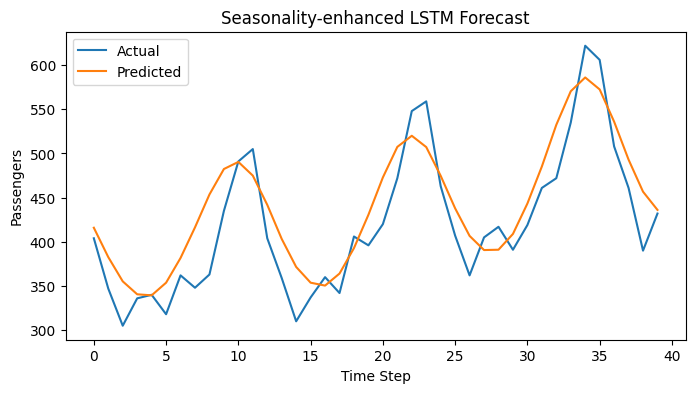

In [81]:
plt.figure(figsize=(8,4))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Seasonality-enhanced LSTM Forecast')
plt.xlabel('Time Step')
plt.ylabel('Passengers')
plt.legend()
plt.show()